# Proyek Akhir: Membuat Sistem Rekomendasi Buku
<hr>

## Data Diri
Nama: Daffa Albari <br>
Email: daffaa.albari@gmail.com <br>
Dataset: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


## Load Data

In [2]:
books = pd.read_csv('./data/Books.csv')
ratings = pd.read_csv('./data/Ratings.csv')
users = pd.read_csv('./data/Users.csv')

C:\Users\daffa\AppData\Local\Temp\ipykernel_24084\2675241246.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('./data/Books.csv')


In [3]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [4]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [5]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


## Data Understanding

### 2.1 Jumlah data dalam masing-masing tabel|

In [6]:
print('Jumlah data buku: ', len(books['ISBN'].unique()))
print('Jumalah data rating: ', len(ratings['User-ID'].unique()))
print('Jumlah data user: ', len(users['User-ID'].unique()))

Jumlah data buku:  271360
Jumalah data rating:  105283
Jumlah data user:  278858


### 2.2 Univariate Exploratory Data Analysis (EDA)

Variabel-variabel yang digunakan dalam analisis ini adalah:
- Books: Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title, Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavours (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon web site.
- Users: Contains the users. Note that user IDs (User-ID) have been anonymized and map to integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL-values.
- Ratings: Contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

#### Books Variabel

In [7]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [8]:
print('Banyak Data: ', len(books))

Banyak Data:  271360


Berdasarkan output di atas, kita dalam mengetahui bahwa Books.csv memiliki 271360 entri. 

In [9]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [10]:
print('Banyak ISBN: ', len(books['ISBN'].unique()))
print('Banyak Judul: ', len(books['Book-Title'].unique()))
print('Banyak Penulis: ', len(books['Book-Author'].unique()))

Banyak ISBN:  271360
Banyak Judul:  242135
Banyak Penulis:  102023


#### Ratings Variabel

In [11]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [12]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [14]:
ratings.describe()

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [15]:
print('Jumlah user id: ', len(ratings['User-ID'].unique()))
print('Jumlah Book-Rating: ', len(ratings['Book-Rating'].unique()))
print('Jumlah data rating: ', len(ratings))

Jumlah user id:  105283
Jumlah Book-Rating:  11
Jumlah data rating:  1149780


#### Users Variabel

In [16]:
users.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


In [17]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


## Data Preprocessing

### 1. Menggabungkan Data Buku

In [18]:
books_all = np.concatenate((
  books['ISBN'].unique(),
  ratings['ISBN'].unique()
))

books_all = np.sort(np.unique(books_all))
print('Jumlah data buku dan user: ', len(books_all))

Jumlah data buku dan user:  341765


### 2. Menggabungkan Data User

In [19]:
users_all = np.concatenate((
  ratings['User-ID'].unique(),
  users['User-ID'].unique()
))

users_all = np.sort(np.unique(users_all))
print('Jumlah data user: ', len(users_all))

Jumlah data user:  278858


## Data Preparation
Pada tahap ini, dilakukan proses transformasi pada data sehingga menjadi bentuk yang cocok untuk proses pemodelan nantinya. Dalam kasus ini, tahap data preparation dilakukan dengan mengatasi missing value, pengecekan data duplikat, dan penggabungan data buku dan data rating.

### 1. Mengatasi Missing Value

#### Book

In [20]:
book_df = books

book_df.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

Terlihat terdapat nilai kosong atau null pada fitur book author, publisher dan juga Image-URL-L. 

In [21]:
book_df = book_df.dropna()

book_df.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64

#### Ratings

In [22]:
rating_df = ratings

rating_df.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

<Axes: xlabel='Book-Rating'>

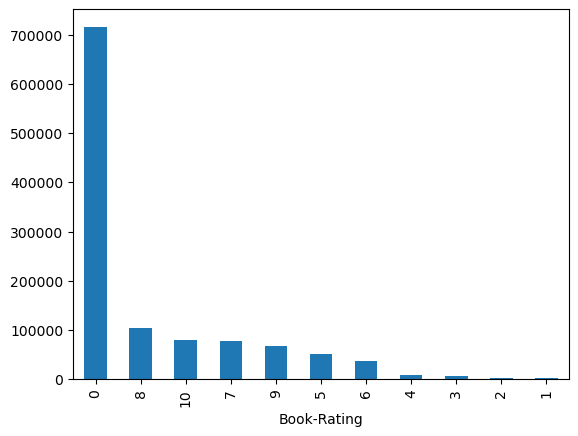

In [23]:
rating_df['Book-Rating'].value_counts().plot(kind='bar')

Sistem rekomendasi biasanya memiliki data umpan balik implisit, di mana pengguna tidak secara eksplisit memberikan penilaian namun tindakan mereka dapat digunakan sebagai indikasi preferensi. Dalam hal ini, peringkat 0 mungkin mewakili peringkat yang hilang atau tidak diketahui, yang sering kali dianggap sebagai "umpan balik negatif implisit". Artinya, pengguna yang belum memberikan rating apa pun untuk sebuah buku belum tentu menunjukkan bahwa mereka tidak menyukai buku tersebut; mereka mungkin tidak menyatakan pendapat apa pun tentang hal itu.

#### Users

In [24]:
user_df = users

user_df.isnull().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

Berdasarkan deskripsi di atas, dapat dilihat bahwa pada dataframe users terdapat atribut yang memiliki nilai kosong atau null, yaitu pada atribut age sebanyak 110.762 data.

In [25]:
user_df['Age'] = user_df['Age'].fillna(user_df['Age'].mean())
user_df.isnull().sum()

User-ID     0
Location    0
Age         0
dtype: int64

### 2. Mengatasi Duplikasi Data

In [26]:
print('Jumlah Data Buku yang duplikat: ', book_df.duplicated().sum())
print('Jumlah Data Rating yang duplikat: ', rating_df.duplicated().sum())
print('Jumlah Data User yang duplikat: ', user_df.duplicated().sum())

Jumlah Data Buku yang duplikat:  0
Jumlah Data Rating yang duplikat:  0
Jumlah Data User yang duplikat:  0


### 3. Data Buku dan Data Rating

In [27]:
books_ratings = pd.merge(book_df, rating_df, on='ISBN')

books_ratings.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11400,0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676,8
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,41385,0


## Model Development dengan Content Based Filtering

In [28]:
# Batasan data
book_df = book_df[:10000]
rating_df = rating_df[:7500]

#### TF-IDF Vectorize

In [29]:
tfidf = TfidfVectorizer()

tfidf.fit(book_df['Book-Author'])


TfidfVectorizer()

In [30]:
tfidf_matrix = tfidf.transform(book_df['Book-Author'])
tfidf_matrix.shape

(10000, 5575)

In [31]:
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
pd.DataFrame(
  tfidf_matrix.todense(),
  columns=tfidf.get_feature_names_out(),
  index=book_df['Book-Title']
).sample(20, axis=1).sample(10, axis=0)

,quin,ry,coen,katie,company,blume,lustbader,hawks,napier,cordingly,cast,cash,kindred,sobel,sachar,clegg,mcalister,candice,limbaugh,stern
Book-Title,,,,,,,,,,,,,,,,,,,,
The Very Hungry Caterpillar Board Book,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Technical Writing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Five Children and It,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rose Madder,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Becoming a Thinking Christian,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Baby-Sitting Is a Dangerous Job,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sacred Geometry (Wooden Books),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pigs in Heaven,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
In the Shadow of the Vampire: Reflections from the World of Anne Rice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Cosine Similarity

In [33]:
# Menghitung cosine similarity pada matrix tfidf
cosine_sim = cosine_similarity(tfidf_matrix)

cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Pada tahapan ini, kita menghitung cosine similarity dataframe tfidf_matrix yang kita peroleh pada tahapan sebelumnya. Dengan satu baris kode untuk memanggil fungsi cosine similarity dari library sklearn, kita telah berhasil menghitung kesamaan (similarity) antar restoran. Kode di atas menghasilkan keluaran berupa matriks kesamaan dalam bentuk array. 

In [34]:
cosine_sim_df = pd.DataFrame(
  cosine_sim,
  columns=book_df['Book-Title'],
  index=book_df['Book-Title']
)

print(cosine_sim_df.shape)
cosine_sim_df.head()

(10000, 10000)


Book-Title,Classical Mythology,Clara Callan,Decision in Normandy,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,The Mummies of Urumchi,The Kitchen God's Wife,What If?: The World's Foremost Military Historians Imagine What Might Have Been,PLEADING GUILTY,Under the Black Flag: The Romance and the Reality of Life Among the Pirates,Where You'll Find Me: And Other Stories,...,Kaplan GRE Exam 2004,Around the World in Eighty Days (Tor Classics),The Exploits of the Incomparable Mulla Nasrudin / The Subtleties of the Inimitable Mulla Nasrudin,The Hours : A Novel,Beloved (Penguin Great Books of the 20th Century),Read This and Tell Me What It Says : Stories (Bard Book),The Star Rover,Die Keltennadel.,Tod in der Datscha.,Dunkel.
Book-Title,,,,,,,,,,,,,,,,,,,,,
Classical Mythology,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Clara Callan,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Decision in Normandy,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Mummies of Urumchi,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Mendapatkan Rekomendasi

In [39]:
def author_recommendation(title, similarity_data=cosine_sim_df, items=book_df[['Book-Title', 'Book-Author']], k=10):
  index = similarity_data.loc[:,title].to_numpy().argpartition(range(-1, -k, -1))
  closest = similarity_data.columns[index[-1:-(k+2):-1]]
  closest = closest.drop(title, errors='ignore')

  return pd.DataFrame(closest).merge(items).head(k)
  

In [43]:
readed_book_title = 'Decision in Normandy'

In [44]:
author_recommendation(readed_book_title).drop_duplicates()

,Book-Title,Book-Author
0,Isola Dell Caduto,Carlo Lucarelli
1,Un Giorno Dopo L'altro,Carlo Lucarelli
2,Almost blue (Stile libero),Carlo Lucarelli
3,Tecniche di seduzione,Andrea De Carlo
4,Due di due (Bestsellers),Andrea De Carlo
5,Kissing the Witch: Old Tales in New Skins,Emma Donoghue
6,The DREAMS OUR STUFF IS MADE OF: How Science F...,Thomas M. Disch
7,The Bookshop : A Novel,Penelope Fitzgerald
8,Cruel As the Grave,Sharon Kay Penman
9,Naked Lunch,William S. Burroughs


Dapat dilihat bahwa sistem yang telah dibangun berhasil memberikan rekomendasi beberapa judul buku berdasarkan input atau masukan sebuah judul buku, yaitu "Decision in Normandy", dan diperoleh beberapa judul buku berdasarkan model yang telah dibuat

## Model Development dengan Collaborative Filtering Recommendation

### Data Preparation

In [46]:
user_ids = rating_df['User-ID'].unique().tolist()

# Melakukan encoding userID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('Encoded UserID: ', user_to_user_encoded)

# Melakukan proses encoding angka ke user ID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userID: ', user_encoded_to_user)

Encoded UserID:  {276725: 0, 276726: 1, 276727: 2, 276729: 3, 276733: 4, 276736: 5, 276737: 6, 276744: 7, 276745: 8, 276746: 9, 276747: 10, 276748: 11, 276751: 12, 276754: 13, 276755: 14, 276760: 15, 276762: 16, 276765: 17, 276768: 18, 276772: 19, 276774: 20, 276780: 21, 276786: 22, 276788: 23, 276796: 24, 276798: 25, 276800: 26, 276803: 27, 276804: 28, 276806: 29, 276808: 30, 276811: 31, 276812: 32, 276813: 33, 276814: 34, 276817: 35, 276820: 36, 276822: 37, 276827: 38, 276828: 39, 276830: 40, 276832: 41, 276833: 42, 276835: 43, 276837: 44, 276838: 45, 276840: 46, 276842: 47, 276847: 48, 276848: 49, 276850: 50, 276852: 51, 276853: 52, 276854: 53, 276856: 54, 276857: 55, 276859: 56, 276861: 57, 276862: 58, 276863: 59, 276866: 60, 276869: 61, 276870: 62, 276872: 63, 276873: 64, 276875: 65, 276878: 66, 276879: 67, 276884: 68, 276887: 69, 276888: 70, 276889: 71, 276890: 72, 276896: 73, 276904: 74, 276905: 75, 276911: 76, 276912: 77, 276915: 78, 276916: 79, 276925: 80, 276927: 81, 276928: 

In [47]:
book_ids = rating_df['ISBN'].unique().tolist()

# Melakukan encoding bookID
book_to_book_encoded = {x: i for i, x in enumerate(book_ids)}
print('Encoded BookID: ', book_to_book_encoded)

# Melakukan proses encoding angka ke book id
book_encoded_to_book = {i: x for i, x in enumerate(book_ids)}
print(book_encoded_to_book)

Encoded BookID:  {'034545104X': 0, '0155061224': 1, '0446520802': 2, '052165615X': 3, '0521795028': 4, '2080674722': 5, '3257224281': 6, '0600570967': 7, '038550120X': 8, '342310538': 9, '0425115801': 10, '0449006522': 11, '0553561618': 12, '055356451X': 13, '0786013990': 14, '0786014512': 15, '0060517794': 16, '0451192001': 17, '0609801279': 18, '0671537458': 19, '0679776818': 20, '0943066433': 21, '1570231028': 22, '1885408226': 23, '0747558167': 24, '3442437407': 25, '033390804X': 26, '3596218098': 27, '0684867621': 28, '0451166892': 29, '8440682697': 30, '034544003X': 31, '0380000059': 32, '0380711524': 33, '0451167317': 34, '0451454952': 35, '0843920262': 36, '3404122879': 37, '3404182928': 38, '3404611306': 39, '342662429': 40, '3426690179': 41, '3442424216': 42, '3442425573': 43, '3453092007': 44, '3453157745': 45, '3453176944': 46, '3453185137': 47, '3453185323': 48, '3453213025': 49, '3453877241': 50, '3492226604': 51, '3517017442': 52, '3596125006': 53, 'B0000BLD7X': 54, 'N34

In [49]:
rating_df['user'] = rating_df['User-ID'].map(user_to_user_encoded)
rating_df['book'] = rating_df['ISBN'].map(book_to_book_encoded)

C:\Users\daffa\AppData\Local\Temp\ipykernel_24084\1817805439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df['user'] = rating_df['User-ID'].map(user_to_user_encoded)
C:\Users\daffa\AppData\Local\Temp\ipykernel_24084\1817805439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df['book'] = rating_df['ISBN'].map(book_to_book_encoded)


In [50]:
num_users = len(user_encoded_to_user)
print(num_users)
num_books = len(book_encoded_to_book)
print(num_books)

min_ratings = min(rating_df['Book-Rating'])
max_ratings = max(rating_df['Book-Rating'])

679
7076


### Membagi Data untuk training dan validasi

In [51]:
rating_df = rating_df.sample(frac=1, random_state=412)
rating_df

,User-ID,ISBN,Book-Rating,user,book
4362,278418,0060186534,0,678,4063
7083,278418,0590337785,0,678,6681
2346,277565,1862082626,0,308,2264
5413,278418,0373163177,0,678,5087
2266,277523,0446613843,10,288,386
...,...,...,...,...,...
5338,278418,0373114109,0,678,5015
5354,278418,0373114443,0,678,5031
3746,278144,0679459596,0,567,3525
869,277107,081297106X,10,144,859


In [53]:
x = rating_df[['user', 'book']].values
y = rating_df['Book-Rating'].apply(lambda x: (x-min_ratings) / (max_ratings-min_ratings)).values

train_indices = int(0.8 * rating_df.shape[0])

X_train, X_val, y_train, y_val = (
  x[:train_indices],
  x[train_indices:],
  y[:train_indices],
  y[train_indices:]
)

print(x, y)

[[ 678 4063]
 [ 678 6681]
 [ 308 2264]
 ...
 [ 567 3525]
 [ 144  859]
 [ 587 3737]] [0.  0.  0.  ... 0.  1.  0.7]


In [55]:
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError

In [56]:
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_books, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_books = num_books
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer = 'he_normal',
            embeddings_regularizer = keras.regularizers.l2(1e-6)
        )
        self.user_bias      = layers.Embedding(num_users, 1)
        self.book_embedding = layers.Embedding(
            num_books,
            embedding_size,
            embeddings_initializer = 'he_normal',
            embeddings_regularizer = keras.regularizers.l2(1e-6)
        )
        self.book_bias = layers.Embedding(num_books, 1)
    
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:,0])
        user_bias   = self.user_bias(inputs[:, 0])
        book_vector = self.book_embedding(inputs[:, 1])
        book_bias   = self.book_bias(inputs[:, 1])
        
        dot_user_book = tf.tensordot(user_vector, book_vector, 2) 
        
        x = dot_user_book + user_bias + book_bias
        
        return tf.nn.sigmoid(x)

In [58]:
model = RecommenderNet(num_users, num_books, 50)

model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=[RootMeanSquaredError()])

In [59]:
history = model.fit(
  x= X_train,
  y = y_train,
  batch_size=16,
  epochs=30,
  validation_data=(X_val, y_val)
)

Epoch 1/30
375/375 [==============================] - 5s 11ms/step - loss: 0.6576 - root_mean_squared_error: 0.4382 - val_loss: 0.6233 - val_root_mean_squared_error: 0.4149
Epoch 2/30
375/375 [==============================] - 3s 8ms/step - loss: 0.4609 - root_mean_squared_error: 0.3248 - val_loss: 0.5933 - val_root_mean_squared_error: 0.3970
Epoch 3/30
375/375 [==============================] - 4s 10ms/step - loss: 0.4393 - root_mean_squared_error: 0.3151 - val_loss: 0.5687 - val_root_mean_squared_error: 0.3824
Epoch 4/30
375/375 [==============================] - 4s 10ms/step - loss: 0.4206 - root_mean_squared_error: 0.3043 - val_loss: 0.5424 - val_root_mean_squared_error: 0.3668
Epoch 5/30
375/375 [==============================] - 3s 7ms/step - loss: 0.4034 - root_mean_squared_error: 0.2949 - val_loss: 0.5188 - val_root_mean_squared_error: 0.3532
Epoch 6/30
375/375 [==============================] - 3s 7ms/step - loss: 0.3879 - root_mean_squared_error: 0.2862 - val_loss: 0.4981 - v

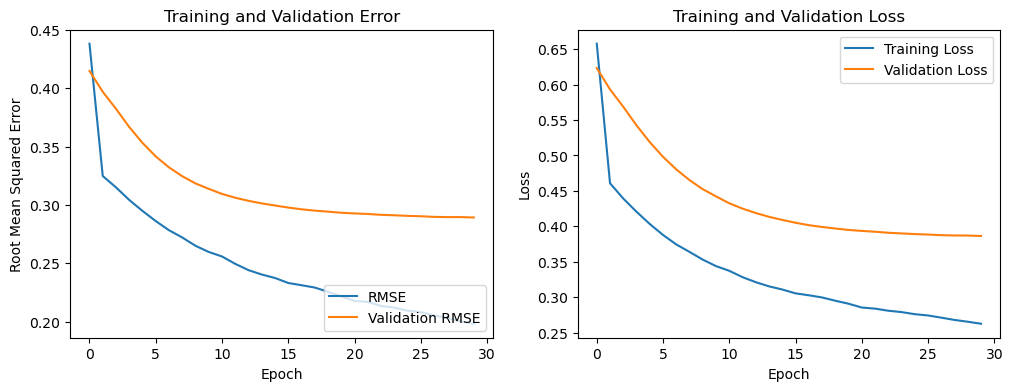

In [60]:
rmse     = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss     = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
plt.plot(rmse,     label='RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.title('Training and Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(loss,     label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

### Mendapatkan Rekomendasi

In [61]:
datasetBook = book_df
datasetRating = rating_df

In [62]:
datasetBook.head(2)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...


In [63]:
datasetRating.head(2)

,User-ID,ISBN,Book-Rating,user,book
4362,278418,0060186534,0,678,4063
7083,278418,0590337785,0,678,6681


In [64]:
userId      = datasetRating['User-ID'].sample(1).iloc[0]
readedBooks = datasetRating[datasetRating['User-ID'] == userId]

notReadedBooks = datasetBook[~datasetBook['ISBN'].isin(readedBooks['ISBN'].values)]['ISBN'] 
notReadedBooks = list(
    set(notReadedBooks).intersection(set(book_to_book_encoded.keys()))
)

notReadedBooks = [[book_to_book_encoded.get(x)] for x in notReadedBooks]
userEncoder    = user_to_user_encoded.get(userId)
userBookArray = np.hstack(
    ([[userEncoder]] * len(notReadedBooks), notReadedBooks)
)

In [88]:
ratings = model.predict(userBookArray).flatten()

topRatingsIndices   = ratings.argsort()[-10:][::-1]
recommendedBookIds = [
    book_encoded_to_book.get(notReadedBooks[x][0]) for x in topRatingsIndices
]

print('Showing recommendations for users: {}'.format(userId))
print('=====' * 8)
print('Book with high ratings from user')
print('-----' * 8)

topBookUser = (
    readedBooks.sort_values(
        by = 'Book-Rating',
        ascending=False
    )
    .head(5)
    .ISBN.values
)

bookDfRows = datasetBook[datasetBook['ISBN'].isin(topBookUser)]
for row in bookDfRows.itertuples():
    print(row['Book-Title'], ':', row.book_author)

print('=====' * 8)
print('Top 10 Books Recommendation')
print('-----' * 8)

recommended_resto = datasetBook[datasetBook['ISBN'].isin(recommendedBookIds)]
for row in recommended_resto.itertuples():
    print(row[2], ':', row[3])

25/25 [==============================] - 0s 2ms/step


Showing recommendations for users: 278418
Book with high ratings from user
----------------------------------------
Top 10 Books Recommendation
----------------------------------------
Rebecca : Daphne Du Maurier
Girl with a Pearl Earring : Tracy Chevalier
The Secret Life of Bees : Sue Monk Kidd
Life of Pi : Yann Martel
The Girl Who Loved Tom Gordon : A Novel : Stephen King
A Cold Heart: An Alex Delaware Novel : JONATHAN KELLERMAN
The Golden Mean: In Which the Extraordinary Correspondence of Griffin &amp; Sabine Concludes : Nick Bantock
Politically Correct Bedtime Stories: Modern Tales for Our Life and Times : James Finn Garner
The Watsons Go to Birmingham - 1963 (Yearling Newbery) : CHRISTOPHER PAUL CURTIS
Oceano Mare : Alessandro Baricco
